In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import pickle

from qiskit import *
from qiskit.visualization import plot_histogram

from utils.graph_funcs import *
from utils.helper_funcs import *

from ansatz import qaoa_plus

matplotlib.rc('xtick', labelsize=18)     
matplotlib.rc('ytick', labelsize=18)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
test_graphs = glob.glob('benchmark_graphs/N14_p20_graphs/*')
test_graphs = sorted(test_graphs, key=lambda g: int(g.split('/')[-1].strip('G.txt')))
print(len(test_graphs))

50


benchmark_graphs/N14_p20_graphs/G41.txt
Optimal: ('00001011011110', 7)


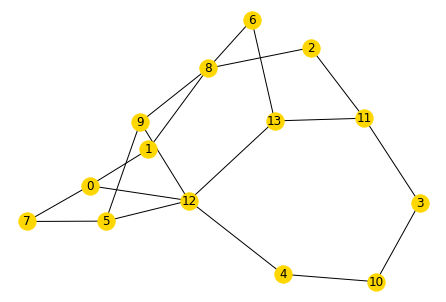

In [3]:
graph = test_graphs[40]
print(graph)
G = graph_from_file(graph)
print('Optimal:', brute_force_search(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

In [24]:
P = 1
params = [1 for i in range(2*P)]
qaoa_circ = qaoa_plus.construct_qaoa_plus(P, G, params, barriers=True)
qaoa_circ.draw(fold=-1)

┌───┐┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░ ┌────────┐
q_0: ┤ H ├┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░─┤ RX(-2) ├
     ├───┤├─────────┤┌─┴─┐┌──────────┐┌─┴─┐ ░ └─────────┘  │                │   ░ └─────────┘  │                │   ░ ┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░ ┌─────────┐                       ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░                                   ░ ├────────┤
q_1: ┤ H ├┤ RZ(0.5) ├┤ X ├┤ RZ(-0.5) ├┤ X ├─░──────────────┼────────────────┼───░──────────────┼────────────────┼───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░─┤ RZ(0.5) ├──■────────────────■───░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░───────────────────────────────────░─┤ RX(-2) ├
     ├───┤└─────────┘└───┘└──────

In [25]:
Lambda = 0.5
P = 3
init_params = [0] * 2 * P
out = qaoa_plus.solve_mis(P, G, Lambda)
print(out)

     fun: -1.623046875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 56
  status: 1
 success: True
       x: array([ 5.88348444e-05, -3.30131406e-05,  6.47814129e-05, -1.61916690e-05,
        2.62380820e-05, -1.73595815e-05])


Optimal MIS: ('0011000001', 3)
0101001010 -> 0.2319%, Is MIS? False
0101000111 -> 0.1953%, Is MIS? False
0101001001 -> 0.1953%, Is MIS? False
1011000001 -> 0.1953%, Is MIS? False
1101010011 -> 0.1953%, Is MIS? False
1101100100 -> 0.1953%, Is MIS? False
1111101011 -> 0.1953%, Is MIS? False
0101111000 -> 0.1831%, Is MIS? False
Expected energy: 1.6121826171875


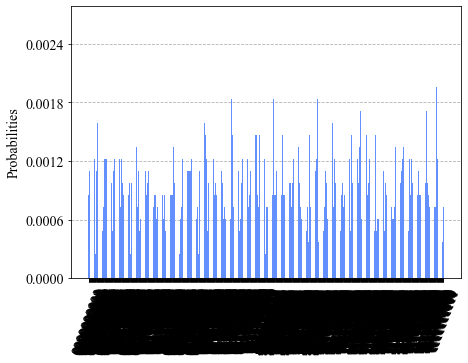

In [27]:
circ = qaoa_plus.construct_qaoa_plus(P, G, params=out['x'], barriers=False, measure=True)
result = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=8192).result()
counts = result.get_counts(circ)
print('Optimal MIS:', brute_force_search(G))
qaoa_plus.top_strs(counts, G, top=8)
print('Expected energy:', qaoa_plus.expectation_value(counts, G, Lambda))
plot_histogram(counts, bar_labels=False)

In [9]:
P = 3
Lambda = 1.5
out = qaoa_plus.solve_mis(P, G, Lambda)
print(out)

ratio = qaoa_plus.get_approximation_ratio(out, P, G)
print('ratio:', ratio)

     fun: -1.27447509765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 74
  status: 1
 success: True
       x: array([ 0.30084504,  1.13863142,  0.95414804, -0.72450201, -0.07954492,
       -0.7794406 ])
ratio: 0.3388671875


In [10]:
np.arange(0.1,1.6,0.2)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5])

In [8]:
P = 3
ratios = []
ranks = []
highest_hw_prob = []
Lambdas = [2, 6, 10, 30, 40, 50]
for Lambda in Lambdas:
    print('Lambda:', Lambda)
    out = qaoa_plus.solve_mis(P, G, Lambda)
    ratio = qaoa_plus.get_approximation_ratio(out, P, G)
    ranked_probs = qaoa_plus.get_ranked_probs(P, G, out['x'])
    largest_hw = 0
    for i, tup in enumerate(ranked_probs):
        if tup[2] and hamming_weight(tup[0]) > largest_hw:
            largest_hw = hamming_weight(tup[0])
            largest_hw_prob = tup[1]
            
    ratios.append(ratio)
    ranks.append(prob * 100)
    highest_hw_prob.append(largest_hw_prob)
    
    print(Lambda, ratio, rank)

Lambda: 2
01000100000000 (2) -> 3.0029%, Ratio = 0.0086, Is MIS? True
01100100000000 (3) -> 2.3682%, Ratio = 0.0101, Is MIS? True
11000100000000 (3) -> 1.1719%, Ratio = 0.0050, Is MIS? False
01000100001000 (3) -> 1.0620%, Ratio = 0.0046, Is MIS? True
01000000000000 (1) -> 1.0254%, Ratio = 0.0015, Is MIS? True
01000110000000 (3) -> 1.0132%, Ratio = 0.0043, Is MIS? True
01001000000000 (2) -> 0.9399%, Ratio = 0.0027, Is MIS? False
01100000000000 (2) -> 0.9277%, Ratio = 0.0027, Is MIS? True
01000000000100 (2) -> 0.9033%, Ratio = 0.0026, Is MIS? True
01000001000000 (2) -> 0.8911%, Ratio = 0.0025, Is MIS? True
01000100000001 (3) -> 0.8789%, Ratio = 0.0038, Is MIS? False
01000100100000 (3) -> 0.8667%, Ratio = 0.0037, Is MIS? False
01000000000010 (2) -> 0.7935%, Ratio = 0.0023, Is MIS? True
01100100100000 (4) -> 0.7080%, Ratio = 0.0040, Is MIS? False
01100110000000 (4) -> 0.6592%, Ratio = 0.0038, Is MIS? True
01101000000000 (3) -> 0.6592%, Ratio = 0.0028, Is MIS? False
01000100010000 (3) -> 0.

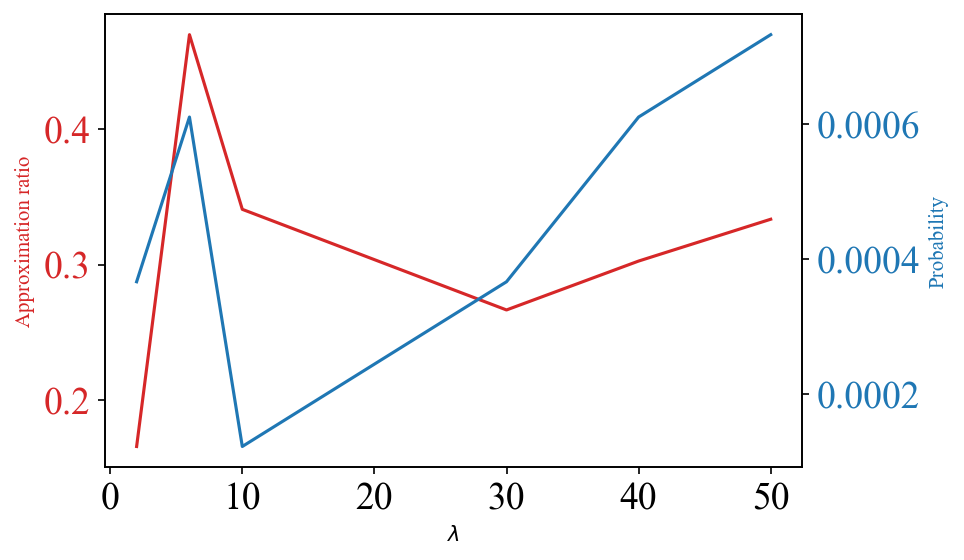

In [9]:
fig, ax1 = plt.subplots(dpi=150)

color = 'tab:red'
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel('Approximation ratio', color=color)
ax1.plot(Lambdas, ratios, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Probability', color=color)
ax2.plot(Lambdas, highest_hw_prob, color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [36]:
np.arange(0.1, 10, 0.7)

array([0.1, 0.8, 1.5, 2.2, 2.9, 3.6, 4.3, 5. , 5.7, 6.4, 7.1, 7.8, 8.5,
       9.2, 9.9])

In [11]:
def load_plus_data(graph_fn):
    data = {'graph':graph_fn, 'plus':{}, 'ansatz':{}}
    
    # Load the QAOA+ data
    all_Ps = glob.glob('benchmark_results/QAOA+*')
    for alg in all_Ps:
        data_array = []
        pval = alg.split('_')[-2]
        all_graphs = glob.glob(alg+'/'+graph_fn+'/*')
        print(alg, pval, len(all_graphs))
        for graphname in all_graphs:
            #print(graphname)
            picklefiles = glob.glob(graphname+'/*')
            for picklefile in picklefiles:
                pickle_array = []
                with open(picklefile, 'rb') as pf:
                    dat = pickle.load(pf)
                    for d in dat:
                        d_array = [d['lambda'], d['ratio'], d['rank'], d['prob']]
                        pickle_array.append(d_array)
                data_array.append(pickle_array)
                
        data_array = np.array(data_array)
        data['plus'][pval] = [np.mean(data_array, axis=0), np.std(data_array, axis=0),
                              np.max(data_array, axis=0),  np.min(data_array, axis=0)]
        
    # Load the QAO-Ansatz data
    all_Ps = glob.glob('benchmark_results/qaoa_P*')
    for alg in all_Ps:
        data_array = []
        pval = alg.split('_')[-2]
        all_graphs = glob.glob(alg+'/'+graph_fn+'/*')
        print(alg, pval, len(all_graphs))
        
        for graphname in all_graphs:
            picklefiles = glob.glob(graphname+'/*')
            rep_ratios = []
            G = graph_from_file('benchmark_graphs/'+'/'.join(graphname.split('/')[-2:])+'.txt')
            opt_mis = brute_force_search(G)[1]
            #print(graphname)
        
            for picklefile in picklefiles:
                with open(picklefile, 'rb') as pf:
                    dat = pickle.load(pf)
                    soln = dat['out'][0]
                    rep_ratios.append(hamming_weight(soln) / opt_mis)
            data_array.append(np.mean(rep_ratios))
        
        data_array = np.array(data_array)
        data['ansatz'][pval] = [np.mean(data_array), np.std(data_array),
                                np.max(data_array),  np.min(data_array)]
    
    
    return data

In [12]:
def plot_plus_data(plus_data, colors, markers, show=True, save=None):
    fig, ax1 = plt.subplots(dpi=150)
    #ax2 = ax1.twinx()
    
    # Plot QAOA+ data
    for pval, color, marker in zip(plus_data['plus'].keys(), colors, markers):
        means, stds, maxs, mins = plus_data['plus'][pval]
        print(means[:,0])
       
        ax1.errorbar(means[:,0], means[:,1], color=color, fmt='-'+marker, label='QAOA+, '+pval, ms=4, lw=1)
        #ax2.errorbar(means[:,0], means[:,3], color=color, fmt=':'+marker, label='QAOA+, '+pval, ms=4, lw=1)
        
    # Plot QAO-Ansatz data
    for pval, c in zip(plus_data['ansatz'].keys(), ['forestgreen', 'limegreen', 'seagreen']):
        qao_dat = plus_data['ansatz'][pval]
        ax1.axhline(y=qao_dat[0], label='QAO-Ansatz, '+pval, lw=1, ls='-.', color=c)
        
    ax1.set_title(plus_data['graph'])
    ax1.set_xlabel(r'$\lambda$')
    ax1.set_ylabel('Approximation ratio')
    #ax2.set_ylabel('Probability of the most likely IS (%)')    
    ax1.legend()
    
    if not save is None:
        plt.savefig(save)
    
    if show:
        plt.show()
        
    plt.close()

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


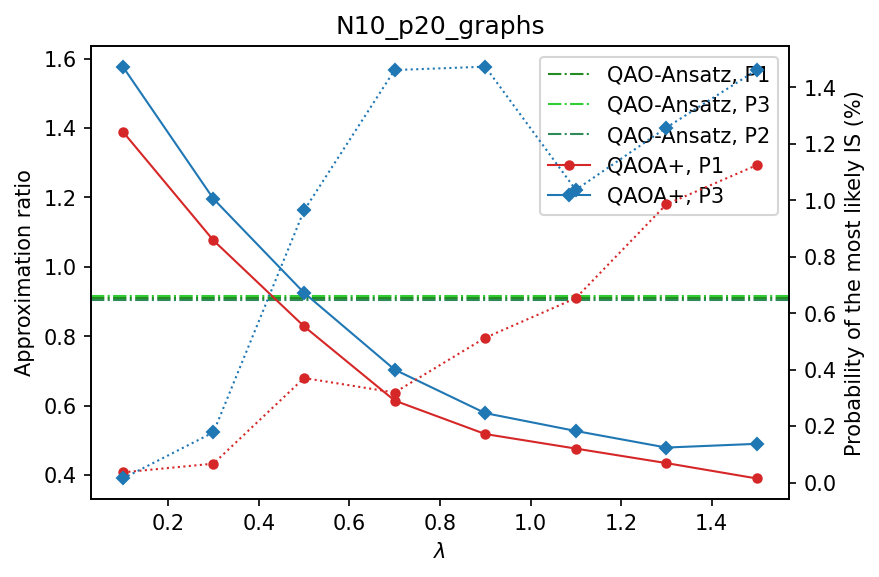

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


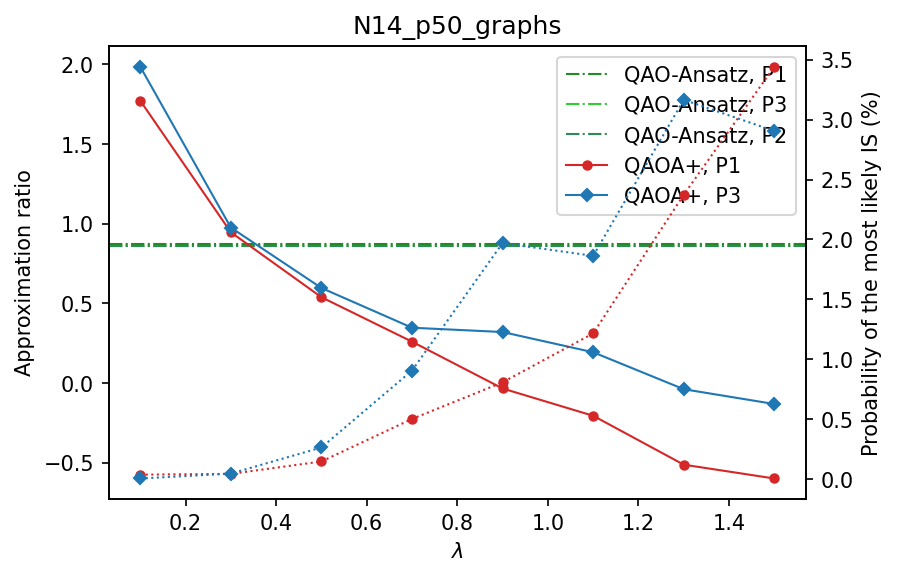

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


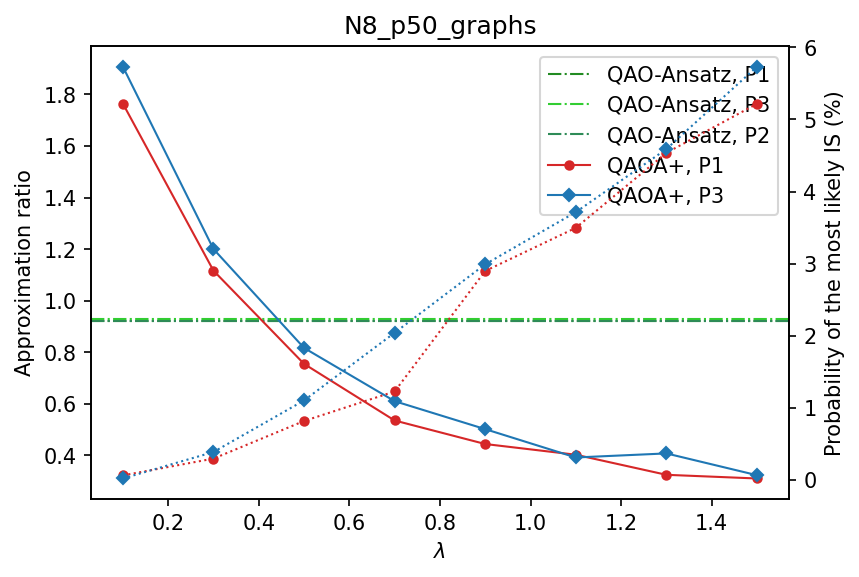

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


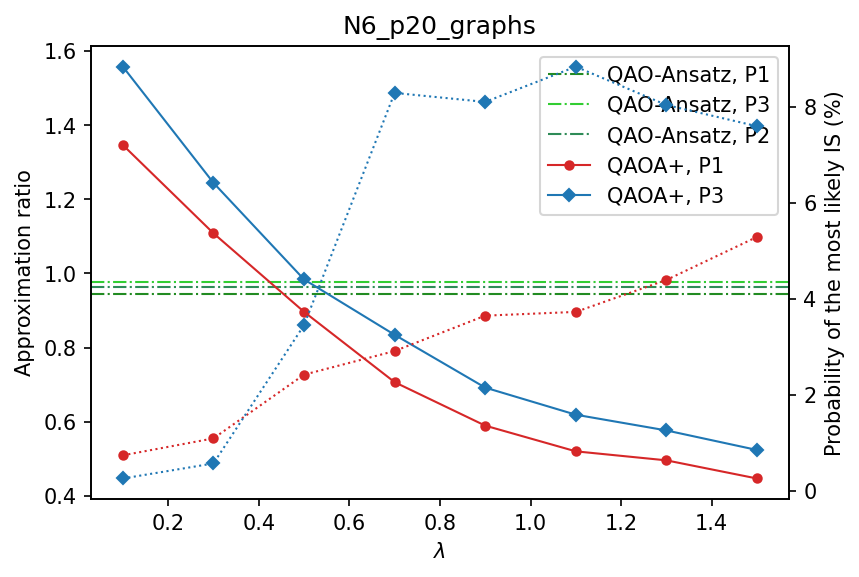

benchmark_results/QAOA+_P1_qasm P1 8
benchmark_results/QAOA+_P3_qasm P3 2
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 45
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


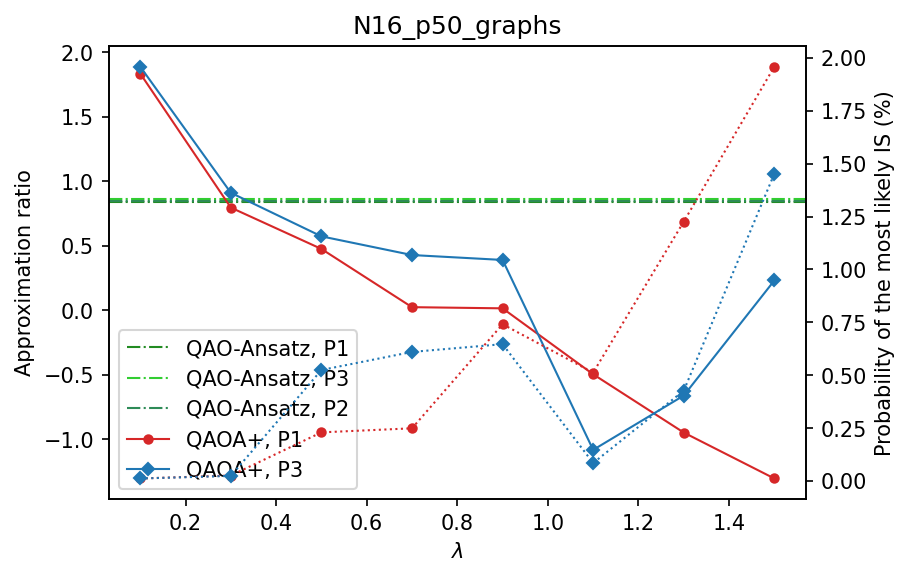

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


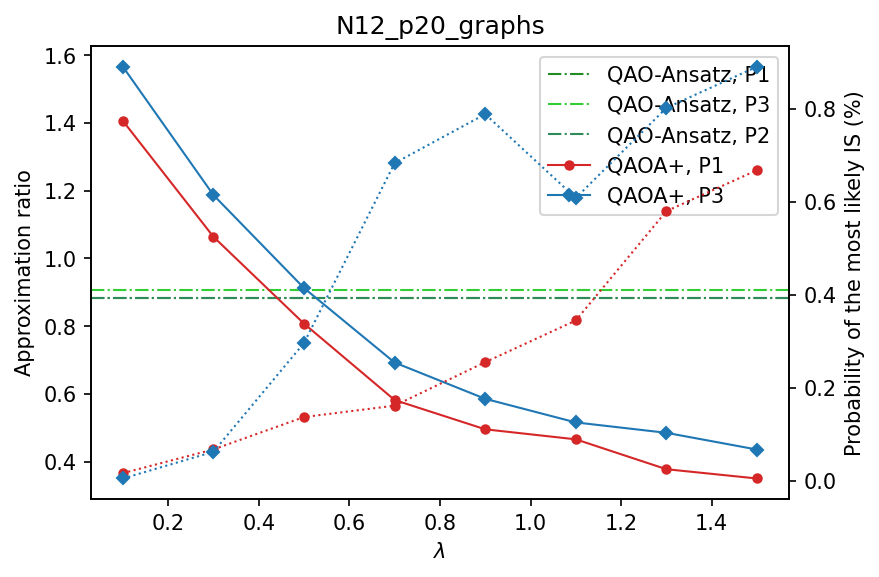

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


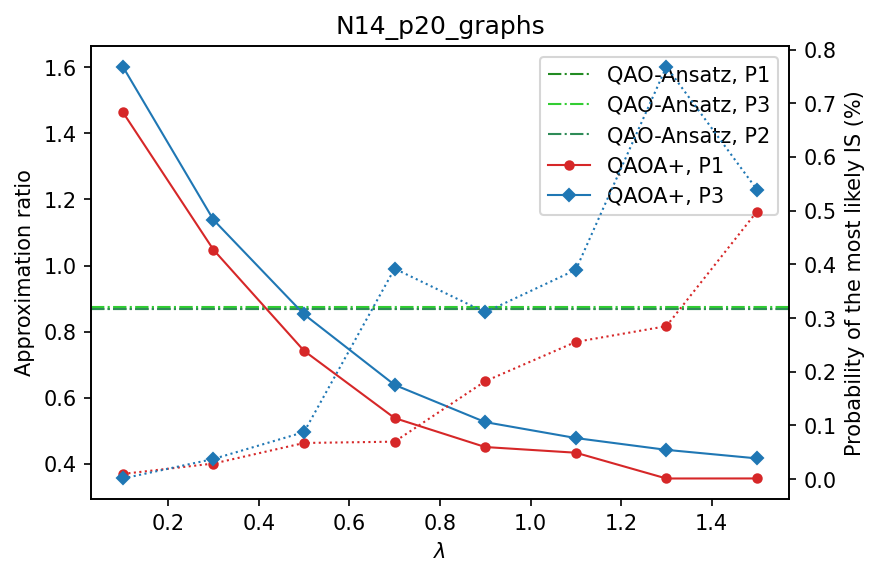

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


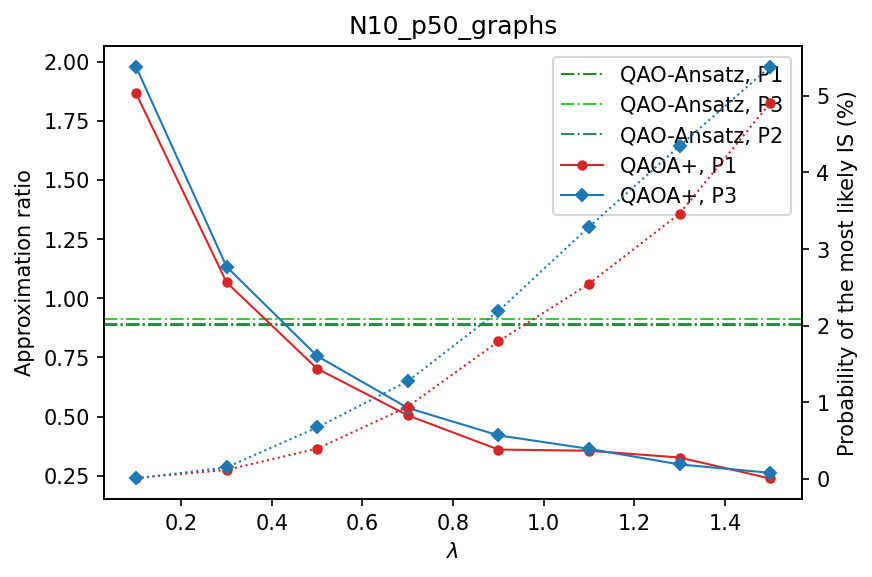

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


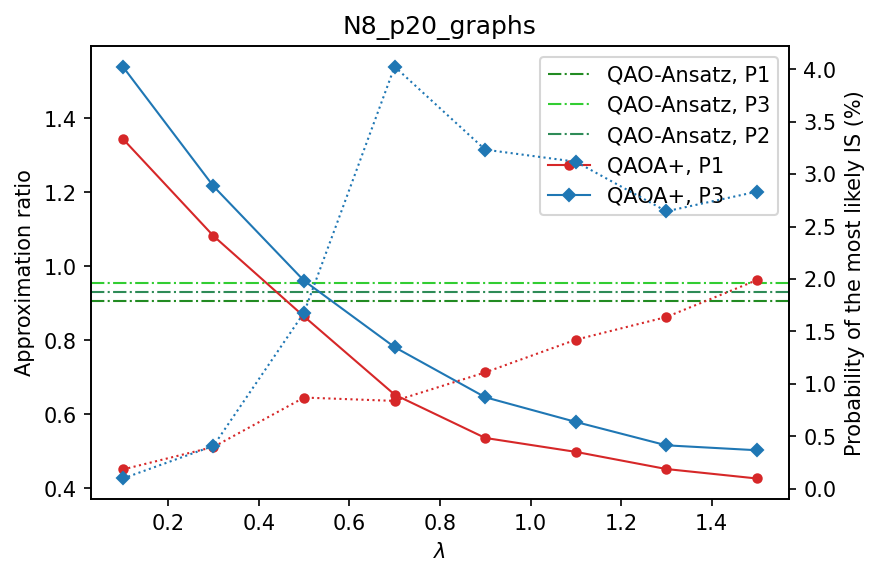

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


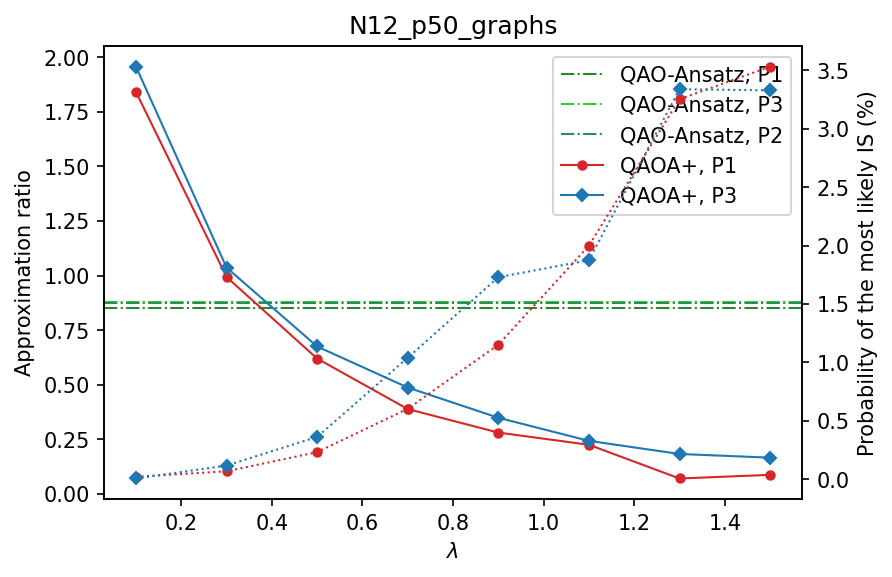

benchmark_results/QAOA+_P1_qasm P1 18
benchmark_results/QAOA+_P3_qasm P3 4
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


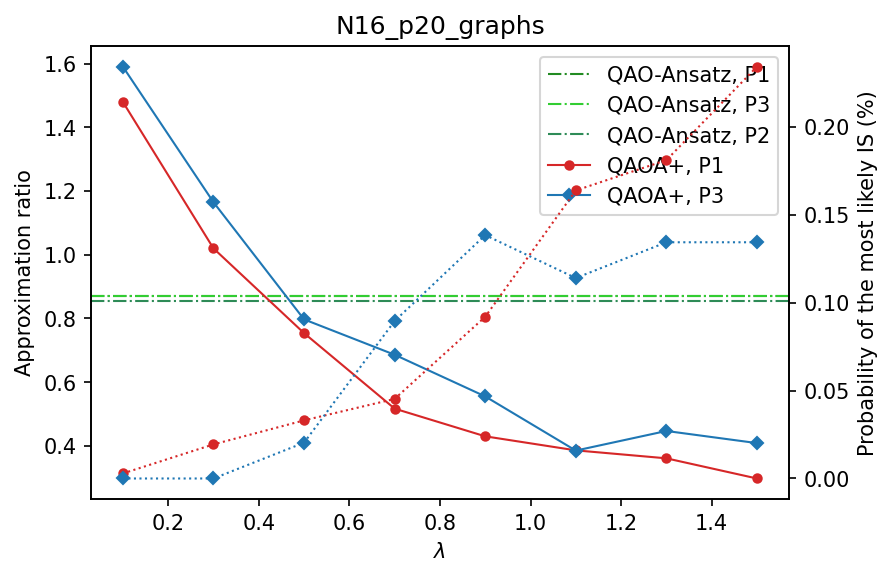

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5]


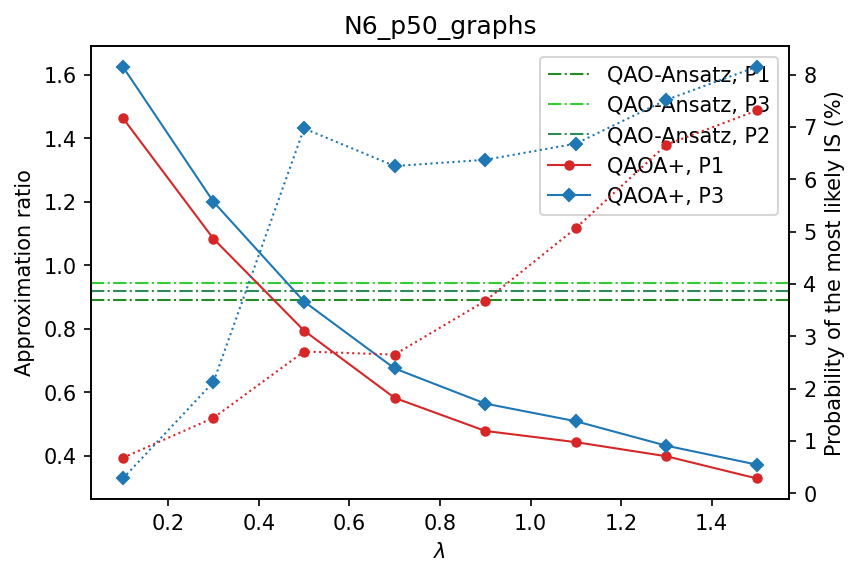

In [170]:
graphs = glob.glob('benchmark_results/QAOA+_P1_qasm/*')
for graph in graphs:
    graph = graph.split('/')[-1]
    plus_data = load_plus_data(graph)
    plot_plus_data(plus_data, ['tab:red', 'tab:blue'], ['o', 'D'], show=True, save=None)

In [22]:
def plot_comp_fig(fig_data, savestr=None, show=True, nrows=1, ncols=1):
    num_plots = len(fig_data)
    fig, ax = plt.subplots(dpi=150, figsize=[18,5], nrows=nrows, ncols=ncols, sharey='row')
    
    for i, dat in enumerate(fig_data):
        if nrows == 1:
            ax1 = ax[i]
        else:
            ax1 = ax[i // int(num_plots / 2), i % int(num_plots / 2)]
        #ax2 = ax1.twinx()
        
        name, graph, plus_data = dat
        print(name)
    
        # Plot QAOA+ data
        colors = ['tab:red', 'tab:blue']
        markers = ['o', 'D']
        for pval, color, marker in zip(plus_data['plus'].keys(), colors, markers):
            means, stds, maxs, mins = plus_data['plus'][pval]

            ax1.errorbar(means[:,0], means[:,1], color=color, fmt='-'+marker, label='QAOA+, {}={}'.format(pval[0], pval[1]), ms=4, lw=1)
            #ax2.errorbar(means[:,0], means[:,3], color=color, fmt=':'+marker, label='QAOA+, '+pval, ms=4, lw=1)
            y1 = [m+s for m, s in zip(means[:,1], stds[:,1])]
            y2 = [m-s for m, s in zip(means[:,1], stds[:,1])]
            ax1.fill_between(means[:,0], y1, y2, color=color, alpha=0.2)

        # Plot QAO-Ansatz data
        #for pval, c in zip(plus_data['ansatz'].keys(), ['forestgreen', 'limegreen', 'seagreen']):
        #    qao_dat = plus_data['ansatz'][pval]
        #    ax1.axhline(y=qao_dat[0], label='QAO-Ansatz, '+pval, lw=1, ls='-.', color=c)

        #if i % int(num_plots / 2) == int(num_plots/2)-1:
        #    ax2.set_ylabel('Probability of the most likely IS (%)', fontsize=18) 
        ax1.set_title(name, fontsize=18)
    
    ax[0].legend(fontsize=16, loc='lower right')
    if nrows == 1:
        ax[0].set_ylabel('Approximation Ratio', fontsize=18)
        for i in range(ncols):
            ax[i].set_xlabel(r'$\lambda$', fontsize=18)
    else:
        for i in [0,1]:
            ax[i,0].set_ylabel('Approximation Ratio', fontsize=18)
        for i in [0,1,2]:
            ax[1,i].set_xlabel(r'$\lambda$', fontsize=18)
    plt.tight_layout()
    
    if not savestr is None:
        plt.savefig(savestr)
        
    if show:
        plt.show()

    plt.close()

In [14]:
# Plotting paper figure
graphs = ['N14_p20_graphs', 'N14_p50_graphs']

figure_data = []
for graph in graphs:
    name = 'Avg Erdos-Renyi (N={}, p={}%)'.format(graph.split('_')[0].strip('N'),
                                                  graph.split('_')[1].strip('p'))
    
    data = load_plus_data(graph)
    
    figure_data.append((name, graph, data))

benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50
benchmark_results/QAOA+_P1_qasm P1 50
benchmark_results/QAOA+_P3_qasm P3 50
benchmark_results/qaoa_P1_qasm P1 50
benchmark_results/qaoa_P3_qasm P3 50
benchmark_results/qaoa_P2_qasm P2 50


Avg Erdos-Renyi (N=14, p=20%)
Avg Erdos-Renyi (N=14, p=50%)


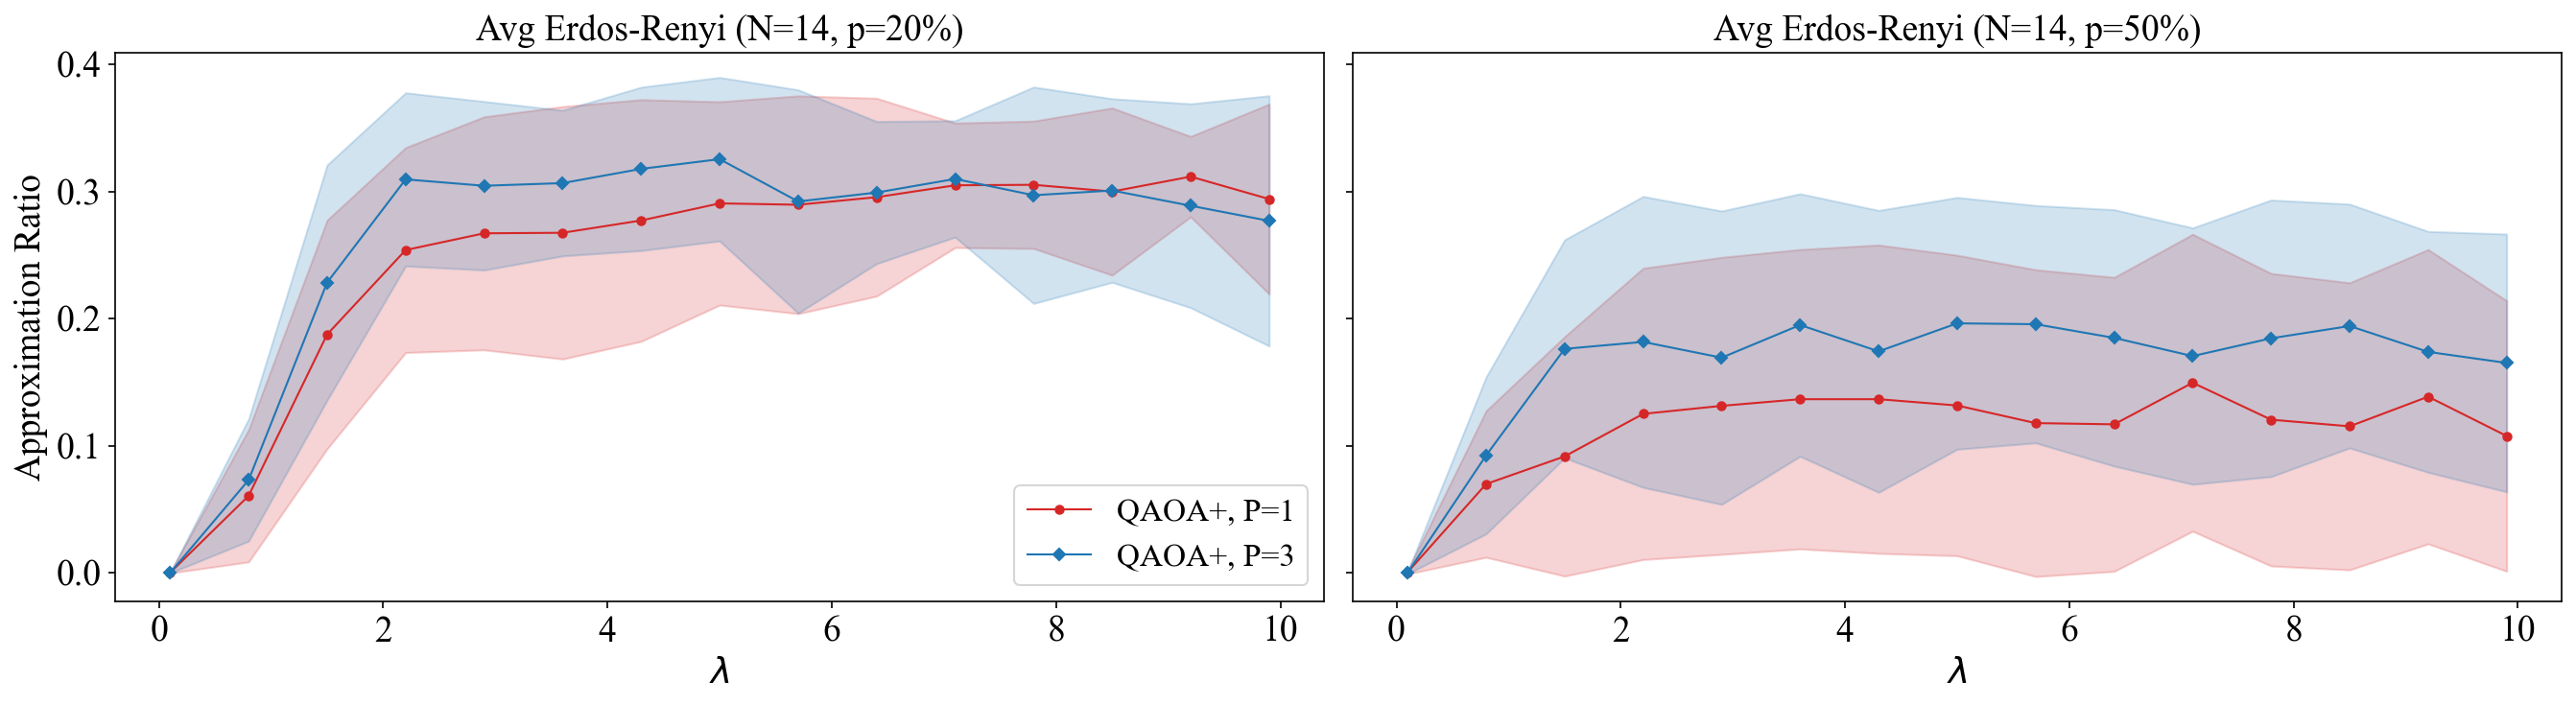

In [23]:
#savestr = 'figures/combined_qaoa_plus.png'
savestr = None
plot_comp_fig(figure_data, savestr=savestr, nrows=1, ncols=2)